In [1]:
from typing import Union
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import sys
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import evalu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(evalu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


# file paths and load data

In [3]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

output_csv = f'{res_dir}_celltypes_logreg_April4.csv'
print(output_csv)

# dredFISH data
dataset = 'DPNMF_PolyA_2021Nov19' # dataset tag
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
fish_path = f'{base_path}fishdata_2022Mar23/' # Zach's new version
# anndata_path = f'{base_path}results/raw_fishdata_Mar30.h5ad'
anndata_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_anndata.h5ad'
# anndata_path = ''

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'
scrna_path2 = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_10x_ctxhippo_a_DPNMF_matrix.h5ad'

# allen tree
allen_tree_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/structures.json'

/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/_celltypes_logreg_April4.csv


In [4]:
%%time
# load dredFISH
TMG = tgh.TissueMultiGraph(name=dataset)
# load raw counts data
if os.path.isfile(anndata_path):
    print('from AnnData')
    TMG.load_from_anndata(anndata_path)
else:
    print('from FishData')
    TMG.load_from_fishdata(fish_path, dataset, output_path=anndata_path)
# normalize (optional for spatial registration)
TMG.normalize_data(norm_cell=True, norm_bit=False)

### for now
data = TMG.data
# print(data)
    
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
ref_data2 = anndata.read_h5ad(scrna_path2)
# print(ref_data)

# allen tree
allen_tree, allen_maps = regu.load_allen_tree(allen_tree_path)

from AnnData


INFO:root:113758 cells, minimum counts = 1248.0


CPU times: user 3.12 s, sys: 1.06 s, total: 4.17 s
Wall time: 4.18 s


In [5]:
# select specific regions
selected_regions = ['Isocortex', 'HPF']
selected_all_sids = regu.expand_regions(allen_tree, selected_regions, 'acronym')

# selected cells
cond_cells = data.obs['region_id'].isin(selected_all_sids)
data = data[cond_cells]
data

View of AnnData object with n_obs × n_vars = 44075 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'cell_name', 'stage_x', 'stage_y', 'coord_x', 'coord_y', 'region_id', 'region_color', 'region_acronym'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors', 'norm_cell'

In [6]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})
ref_data2.obs = ref_data2.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']


# Evaluate and save 

In [7]:
# f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_sample_norm_p52_April6.npy"
f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/celltypes_sample_norm_p52_April6.npy"

y_data = np.load(f, allow_pickle=True)
res = data.obs.copy() #pd.DataFrame(index=data.obs.index)
for i, level in enumerate(levels):
    res[level] = y_data[:,i]
    
# res.to_csv(output_csv, header=True, index=True)
res

,label,pixel_x,pixel_y,nuclei_size,nuclei_signal,cytoplasm_size,cytoplasm_signal,total_size,total_signal,posname,...,stage_x,stage_y,coord_x,coord_y,region_id,region_color,region_acronym,Level_1_class_label,Level_2_neighborhood_label,Level_3_subclass_label
DPNMF_PolyA_2021Nov19_Pos3_cell_1.0,1.0,6.946154,13.064102,390.0,37376.0,94.0,26496.0,479.0,35312.0,Pos3,...,-2412.264446,-3414.258897,-3836.669362,257.071979,366,#15B0B3,TEa6a,Glutamatergic,NP/CT/L6b,L6 CT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_2.0,2.0,11.731343,96.792404,737.0,36368.0,146.0,26160.0,873.0,34224.0,Pos3,...,-2413.824418,-3441.554324,-3864.007917,257.349850,366,#15B0B3,TEa6a,Glutamatergic,NP/CT/L6b,L6 CT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_3.0,3.0,8.584210,230.557892,380.0,42064.0,132.0,34464.0,390.0,38992.0,Pos3,...,-2412.798453,-3485.161873,-3907.519336,254.279457,365,#15B0B3,TEa5,Glutamatergic,L4/5/6 IT Car3,L4/5 IT CTX
DPNMF_PolyA_2021Nov19_Pos3_cell_5.0,5.0,7.058411,385.787384,428.0,46496.0,143.0,39760.0,566.0,45040.0,Pos3,...,-2412.301042,-3535.766687,-3958.045112,251.408807,365,#15B0B3,TEa5,Glutamatergic,L4/5/6 IT Car3,Car3
DPNMF_PolyA_2021Nov19_Pos3_cell_7.0,7.0,9.555555,576.148865,477.0,6816.0,19.0,6400.0,475.0,6832.0,Pos3,...,-2413.115111,-3597.824530,-4020.072828,249.310951,365,#15B0B3,TEa5,Non-Neuronal,Other,SMC-Peri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DPNMF_PolyA_2021Nov19_Pos102_cell_1351.0,1351.0,2025.603882,2292.653809,260.0,7744.0,220.0,8176.0,474.0,7888.0,Pos102,...,-409.346865,2777.594858,2442.321904,-1453.191293,463,#7ED04B,CA2,Non-Neuronal,Other,Astro
DPNMF_PolyA_2021Nov19_Pos102_cell_1352.0,1352.0,2031.969238,2012.783447,651.0,7664.0,114.0,7024.0,651.0,7248.0,Pos102,...,-411.421972,2868.832596,2533.361867,-1446.838662,463,#7ED04B,CA2,Non-Neuronal,Other,Oligo
DPNMF_PolyA_2021Nov19_Pos102_cell_1353.0,1353.0,2031.924072,2435.701660,382.0,4432.0,126.0,4672.0,508.0,4560.0,Pos102,...,-411.407248,2730.961259,2395.642989,-1453.320683,463,#7ED04B,CA2,Non-Neuronal,Other,Oligo
DPNMF_PolyA_2021Nov19_Pos102_cell_1356.0,1356.0,2033.539062,2311.605469,256.0,8960.0,367.0,9360.0,629.0,9184.0,Pos102,...,-411.933734,2771.416617,2436.029118,-1450.897083,463,#7ED04B,CA2,Non-Neuronal,Other,Oligo


In [8]:
# # input_celltypes = f'{res_dir}noHarmony_March30_v4_isocortex_hpf.csv'
# # print(input_celltypes)
input_embed1 = f'{res_dir}Joint_UMAP_isocortex_hpf_April1.csv'
print(input_embed1)
input_embed2 = f'{res_dir}Joint_UMAP_isocortex_hpf_subsamp100_level1_April1.csv'
print(input_embed2)

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'


/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_isocortex_hpf_April1.csv
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_isocortex_hpf_subsamp100_level1_April1.csv


In [9]:
# analysis
with open(meta_path, 'r') as fh:
    meta = json.load(fh)

In [10]:
# results
dftypes = res.copy() #pd.read_csv(input_celltypes, index_col=0)
dftypes = dftypes.filter(regex=r'^Level_[0-9]', axis=1)
levels = dftypes.columns.values

# update data
# data.obs = data.obs.join(dftypes)
for level in levels:
    if level in data.obs.columns.values:
        data.obs = data.obs.drop(level, axis=1)
data.obs = data.obs.join(dftypes)

# update the joint one
dfembed1 = pd.read_csv(input_embed1, index_col=0)
dfembed2 = pd.read_csv(input_embed2, index_col=0)
dfembed1 = dfembed1.join(pd.concat([data.obs, ref_data.obs]))
dfembed2 = dfembed2.join(pd.concat([data.obs, ref_data.obs]))

print(dftypes.shape, dfembed1.shape, dfembed2.shape, data.obs.shape)

(44075, 3) (117422, 79) (44375, 79) (44075, 23)


/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/scipy/sparse/_base.py:655: RuntimeWarning:

invalid value encountered in true_divide



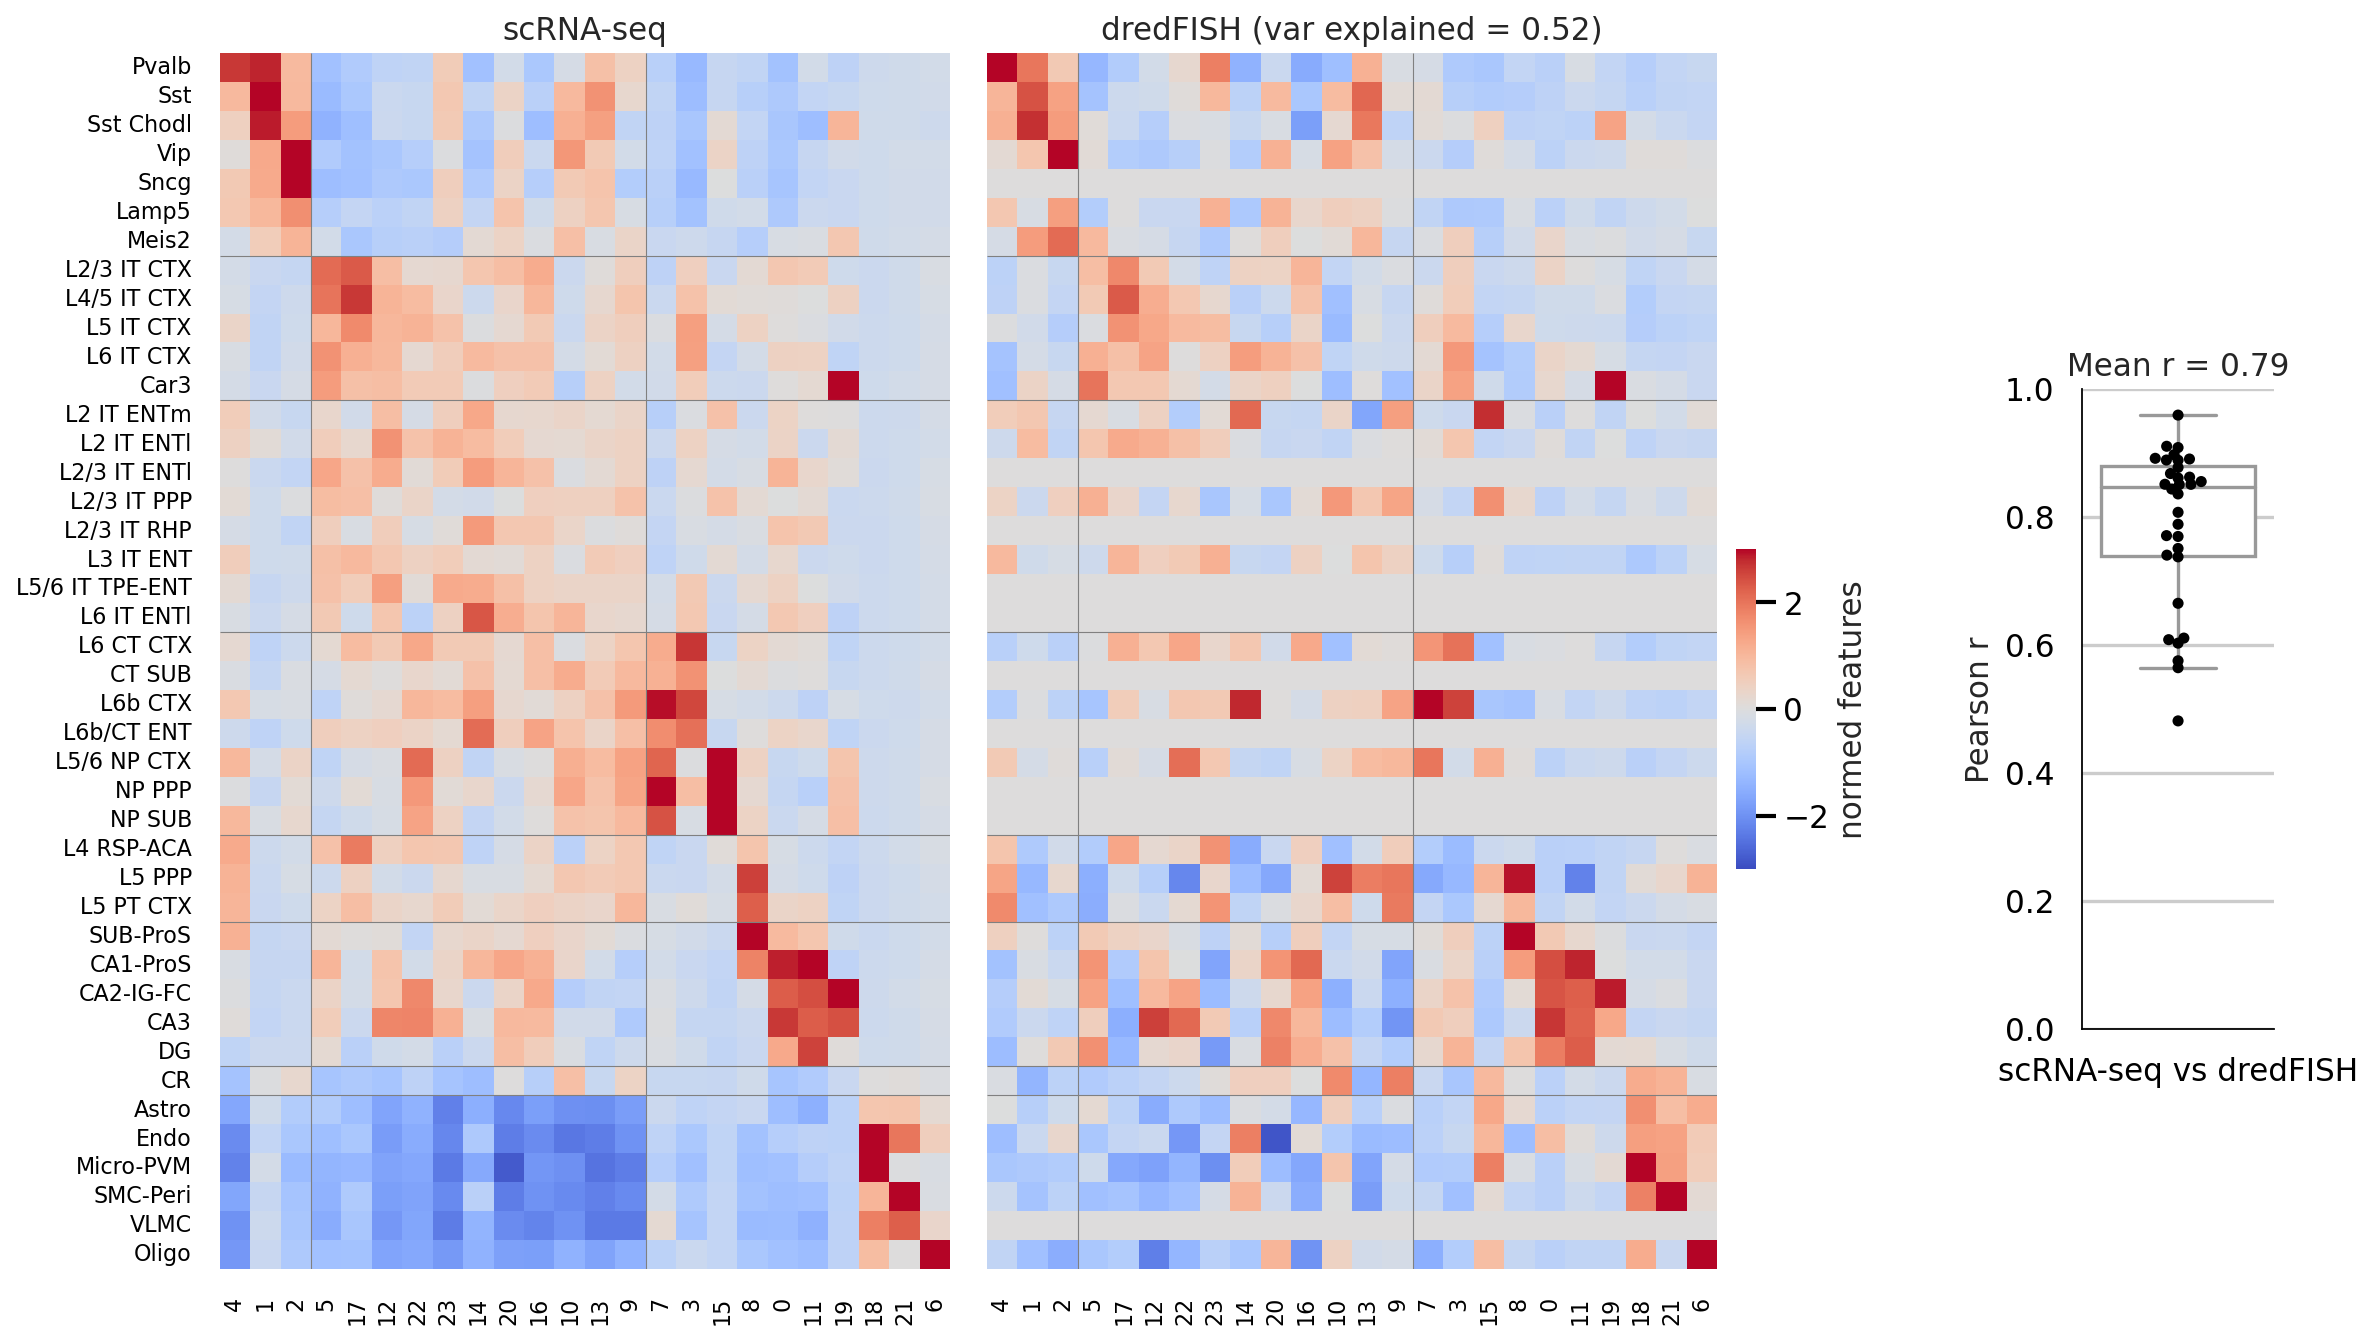

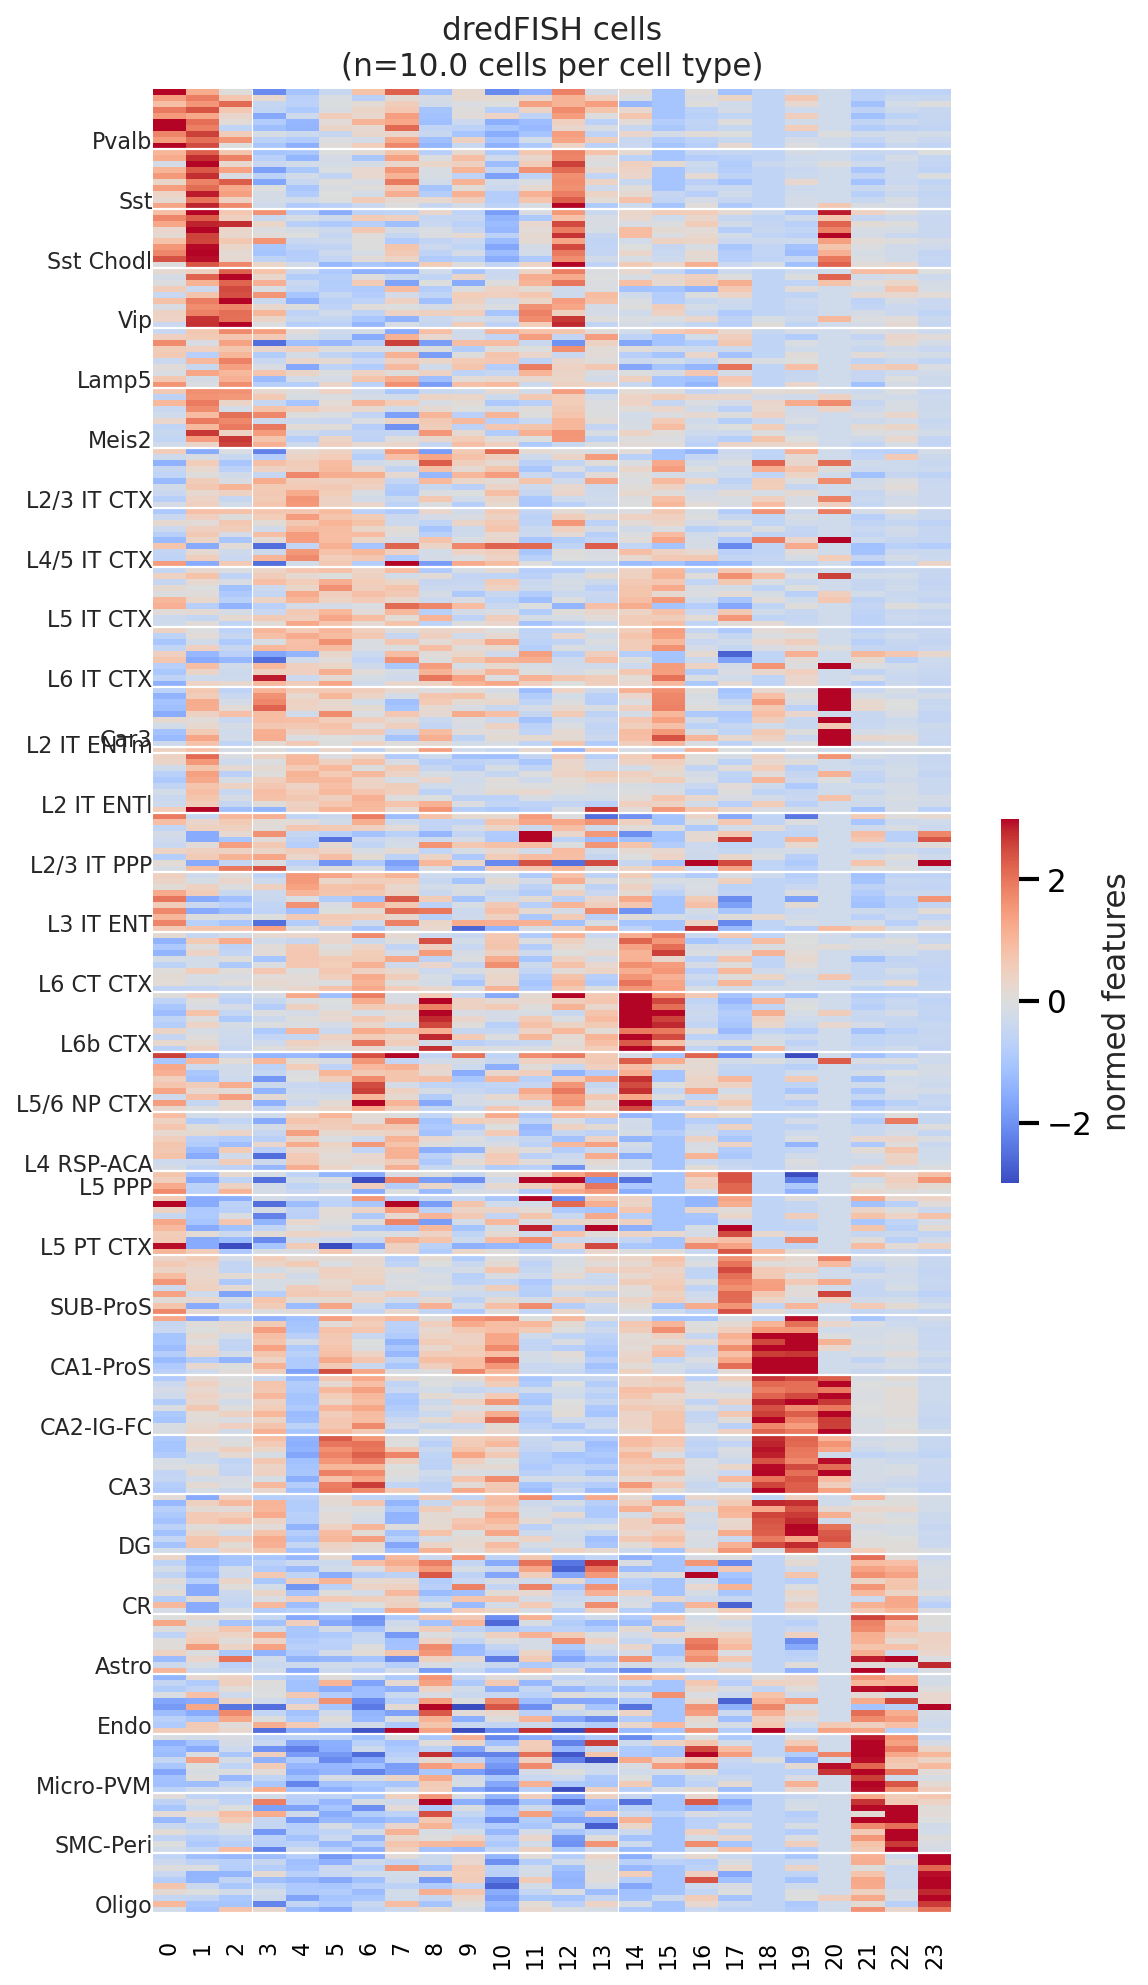

In [11]:

# importlib.reload(evalu)
resobj = evalu.Level3Res(meta, levels, 
                ref_data, data, 
                refdata_name='scRNA-seq', data_name='dredFISH',
                embed=True, df_embed=dfembed1,
               )

resobj.plot_genes()

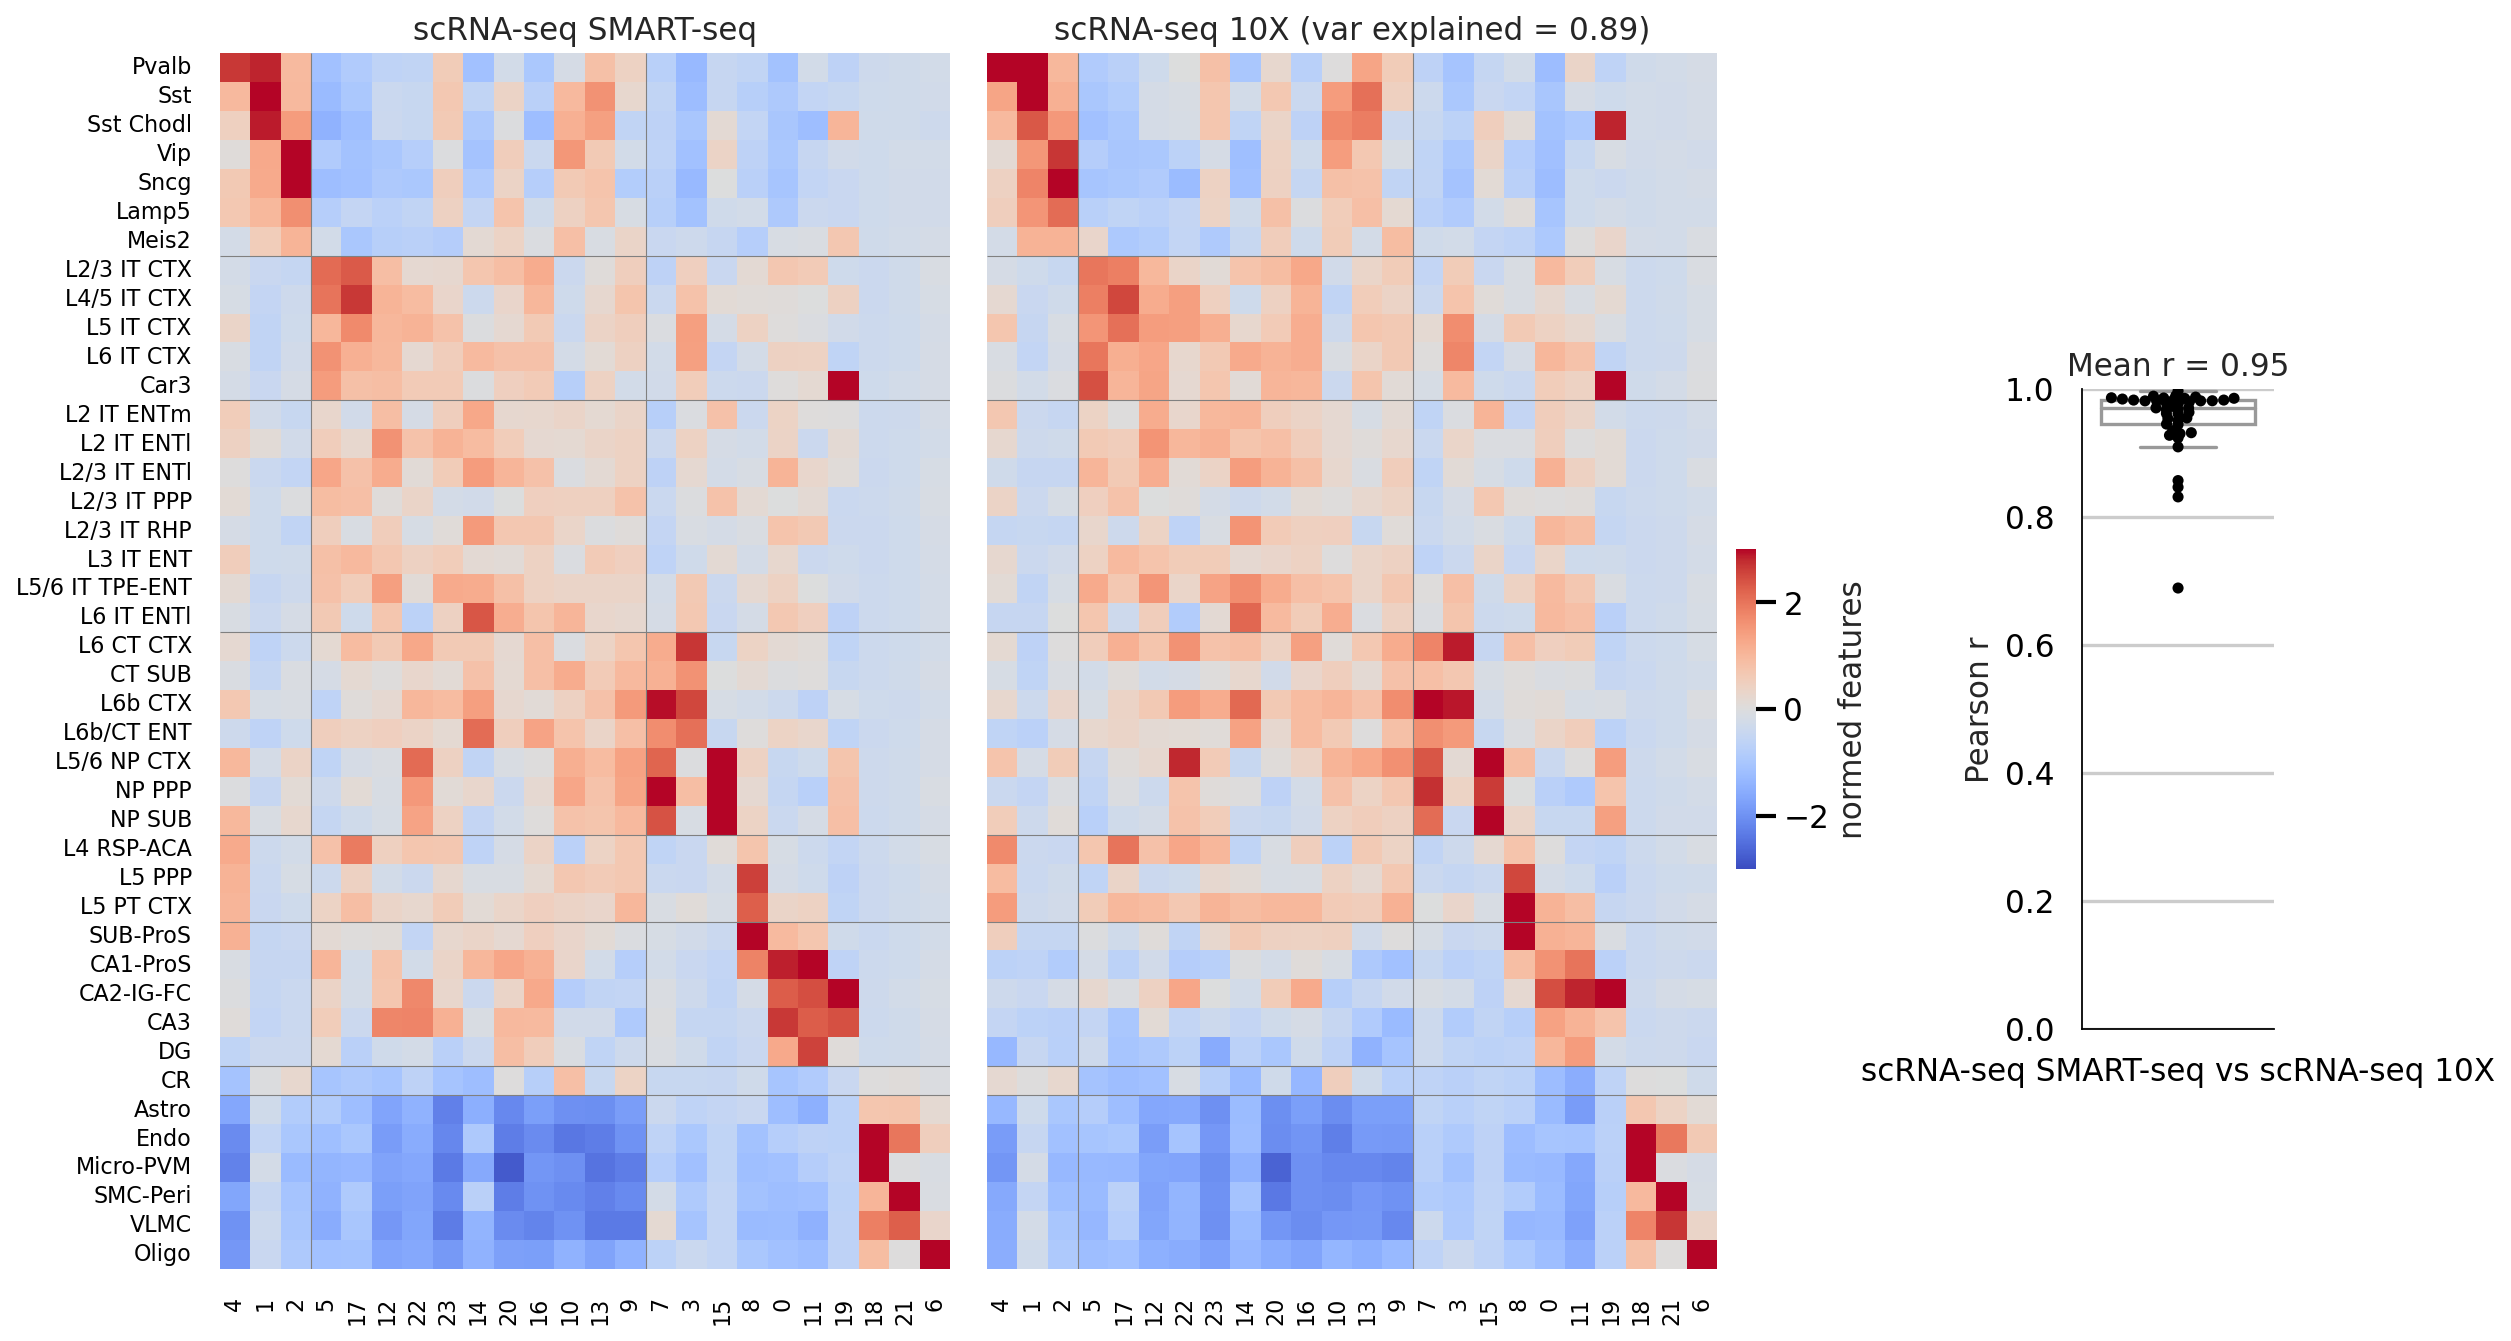

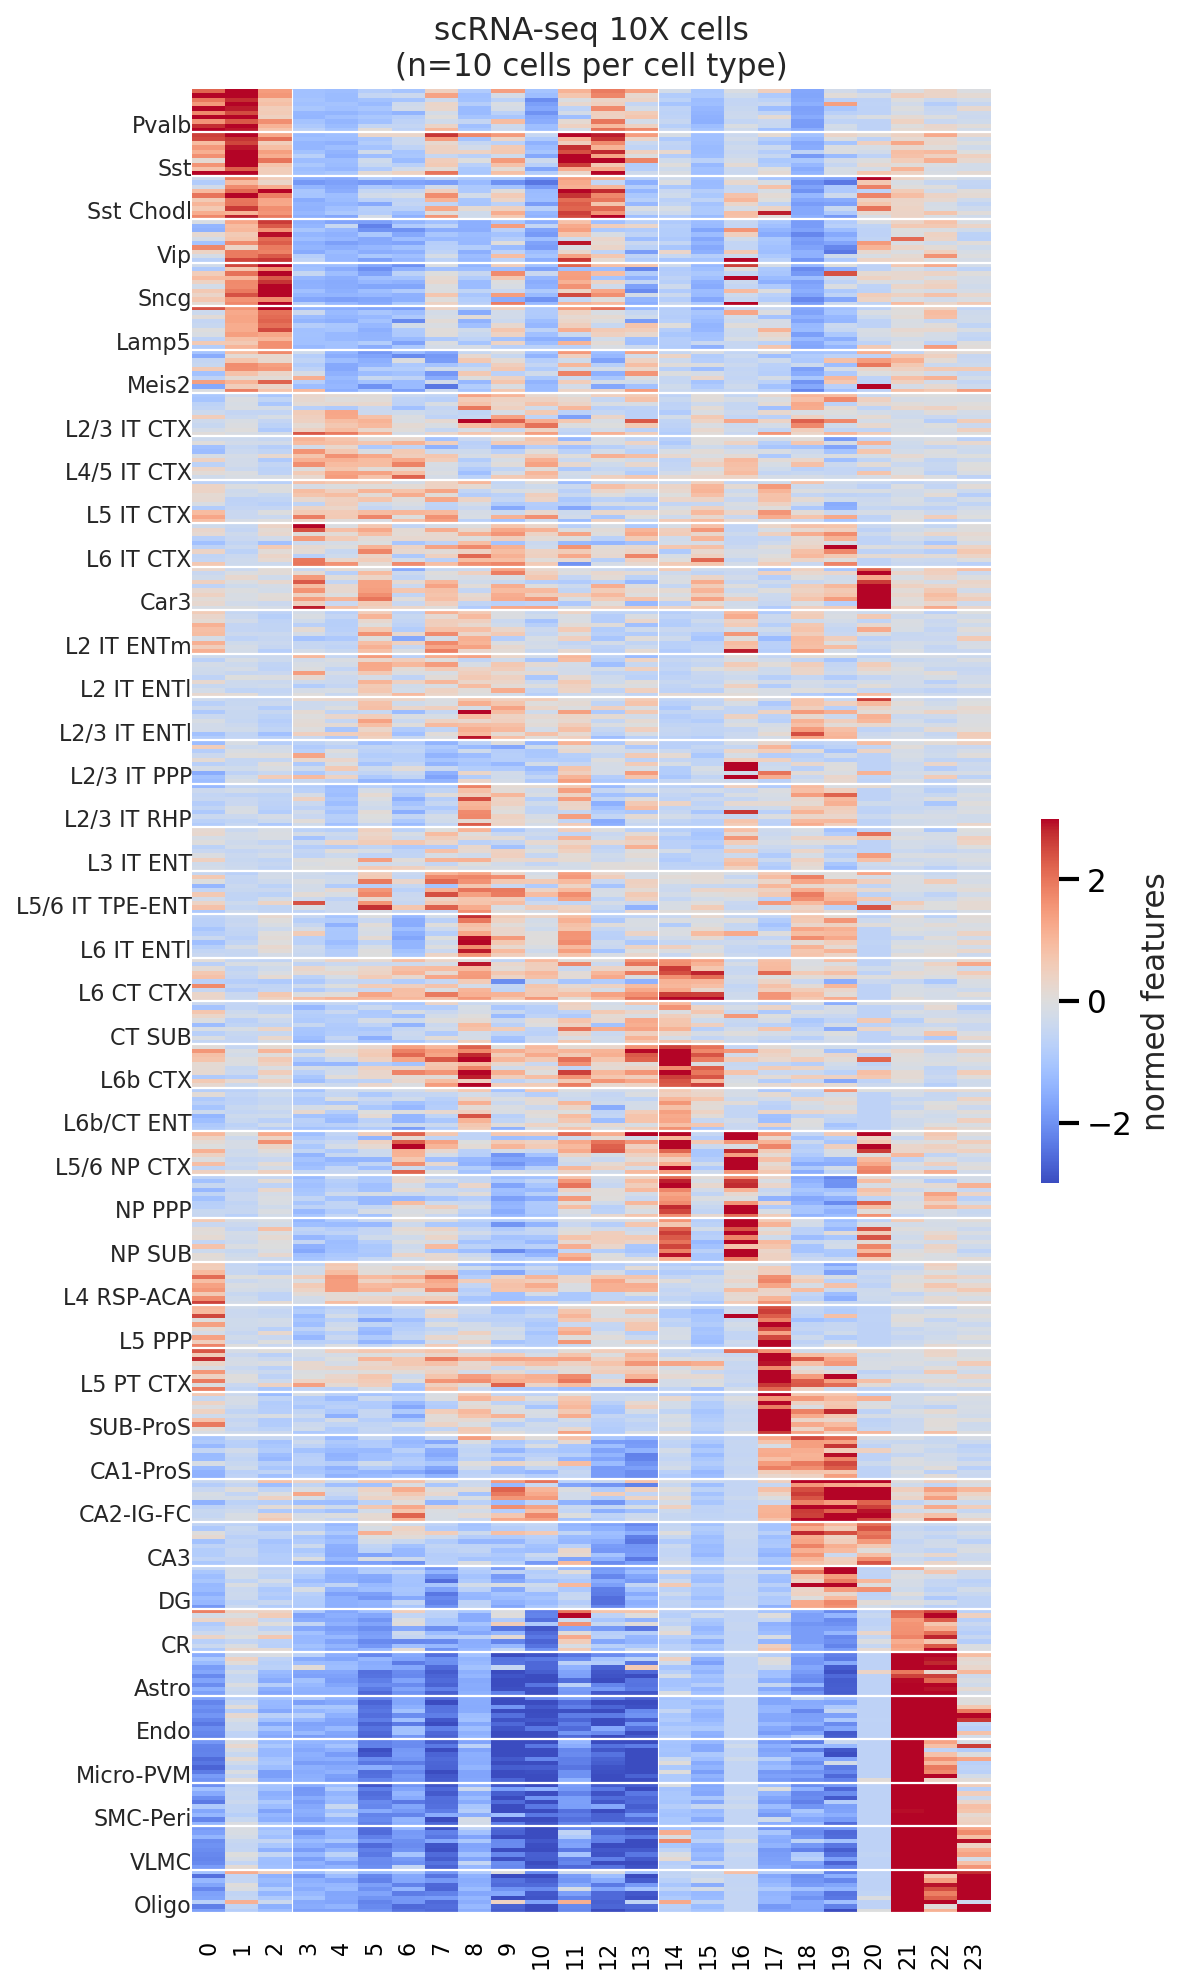

In [12]:
importlib.reload(evalu)

resobj = evalu.Level3Res(meta, levels, 
                ref_data, ref_data2, 
                refdata_name='scRNA-seq SMART-seq', data_name='scRNA-seq 10X',
                data_layer='', # instead of normed_cell
                embed=True, df_embed=dfembed1,
               )

resobj.plot_genes()

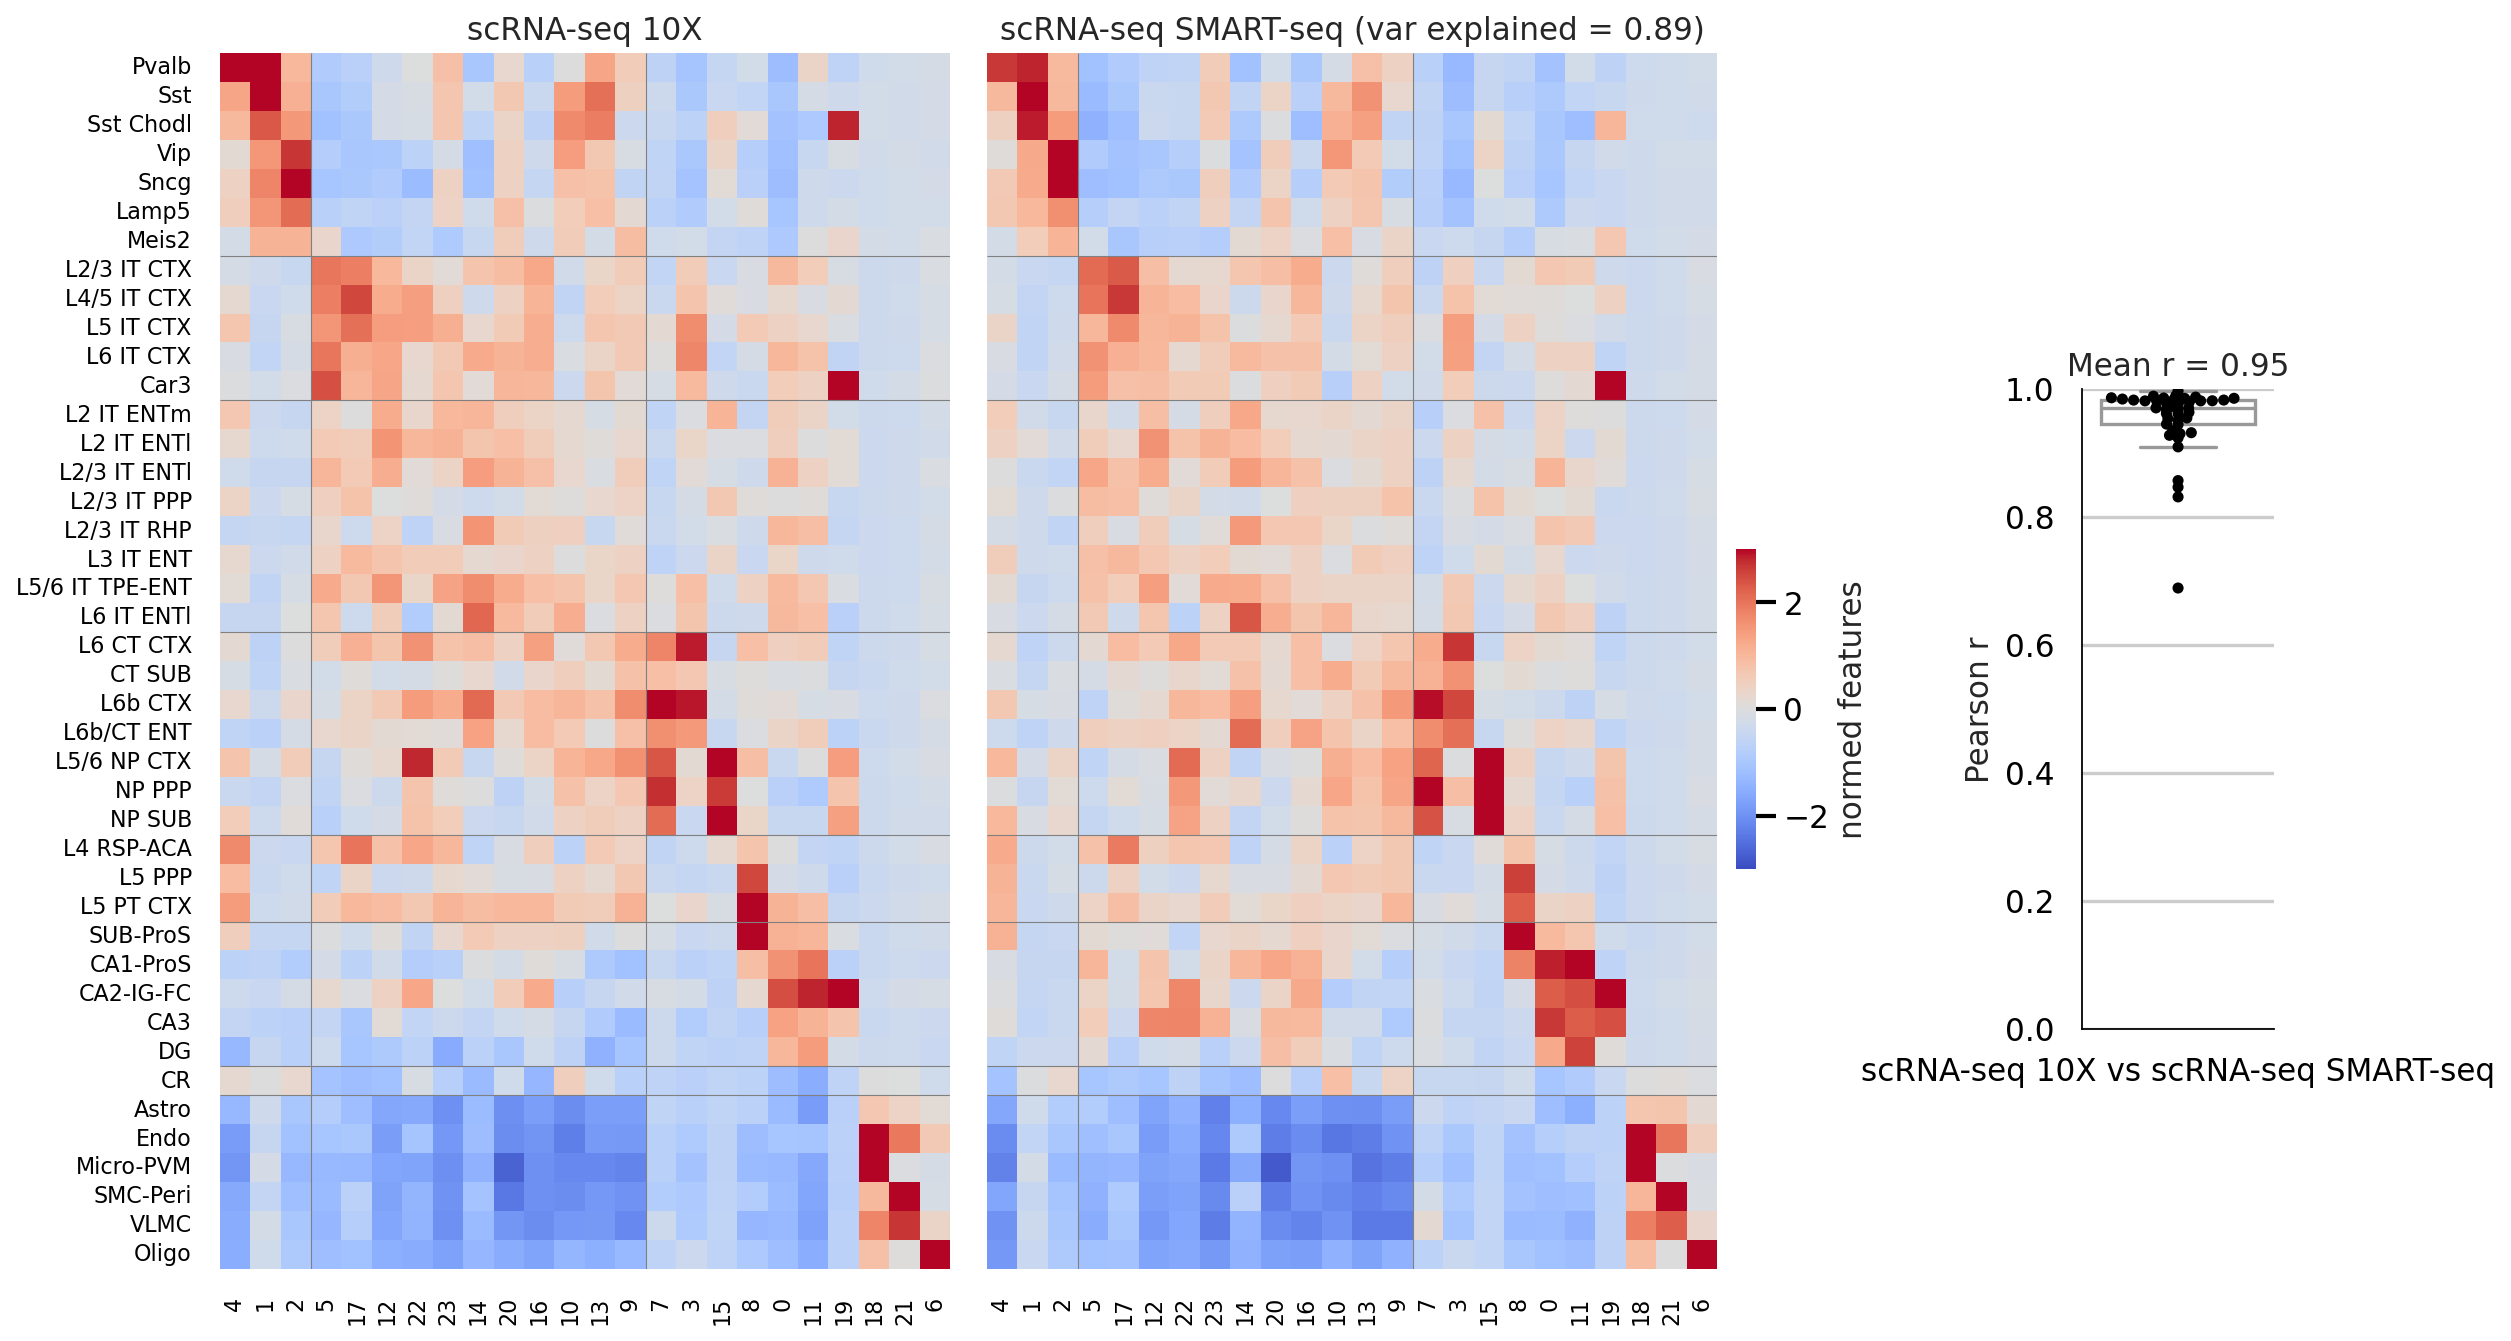

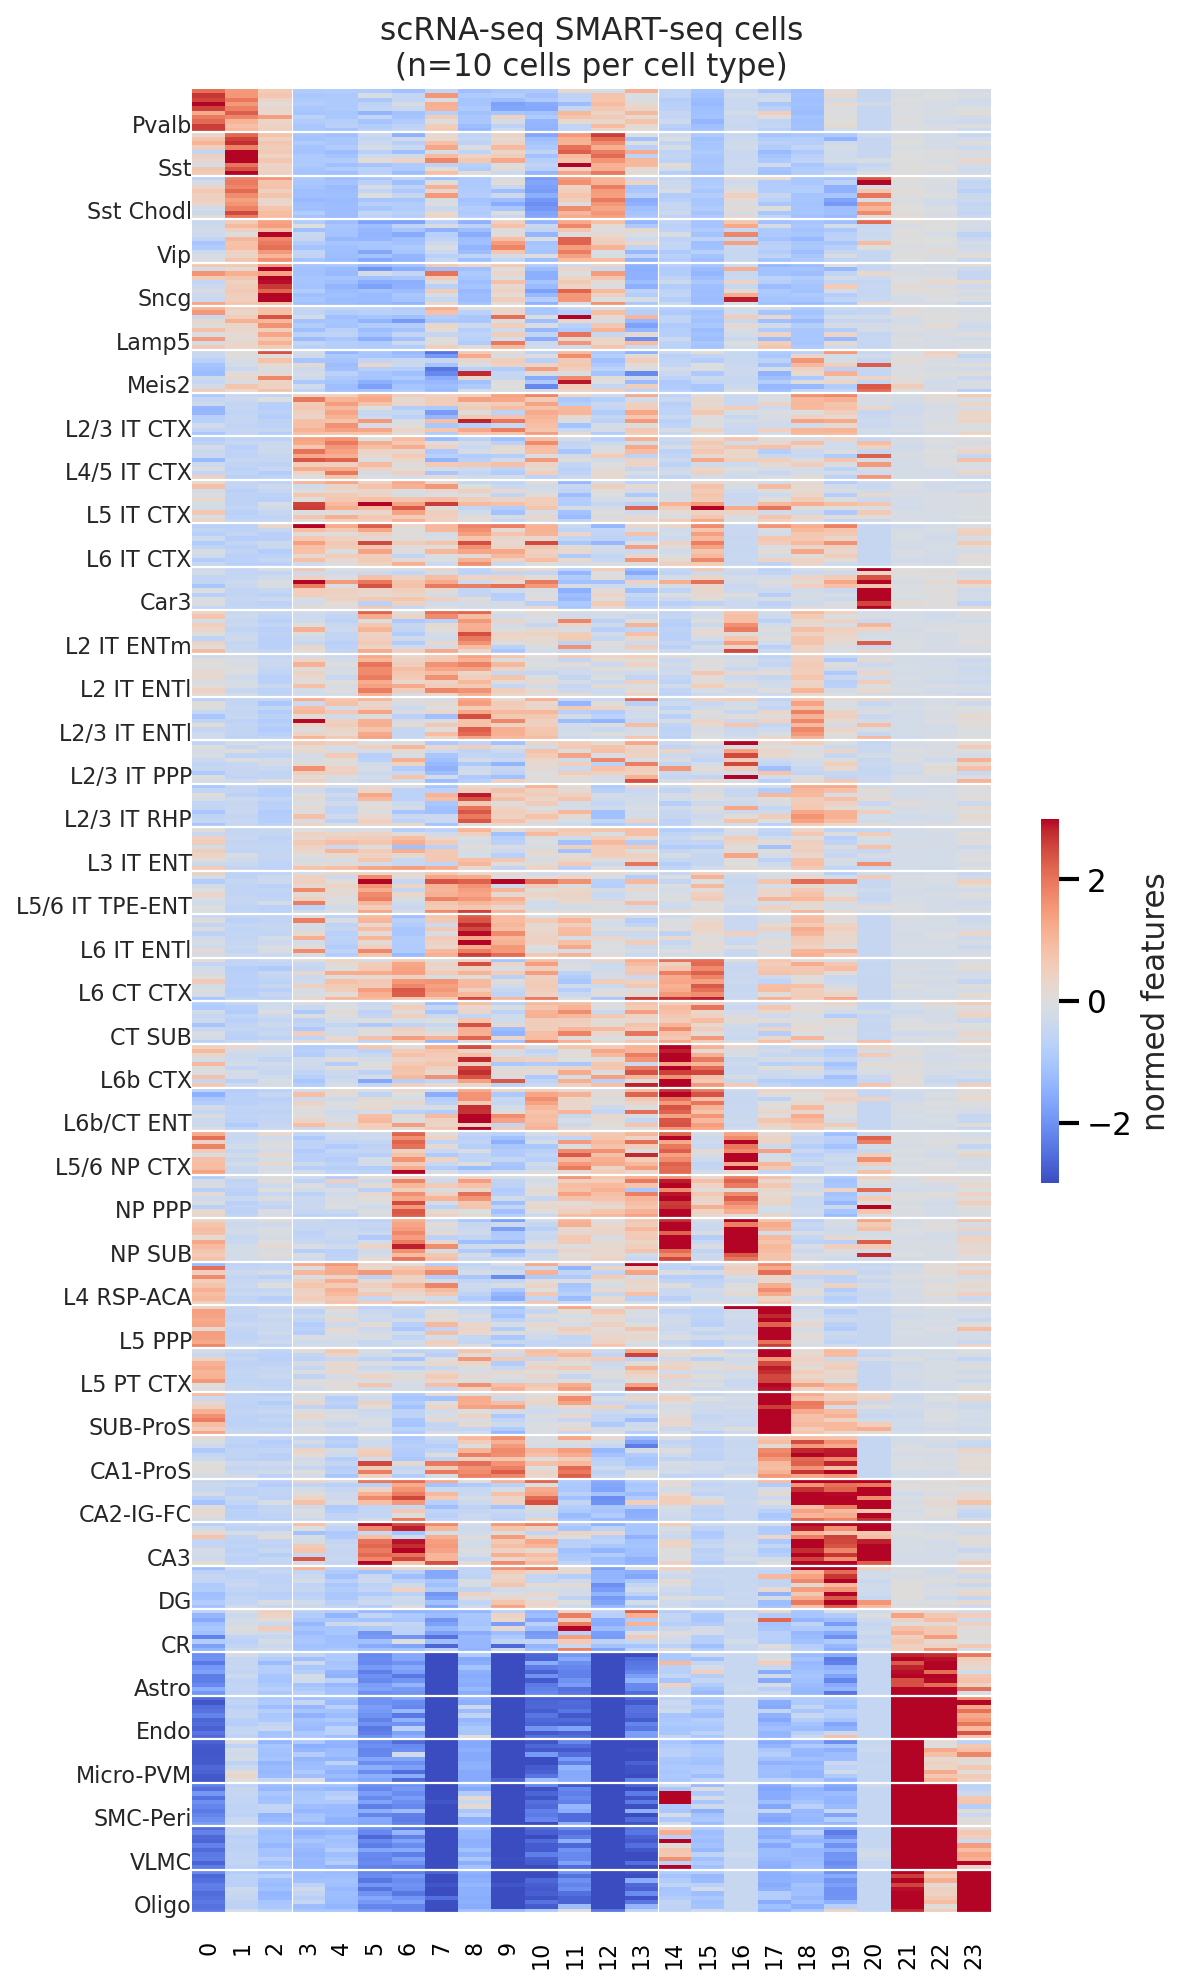

In [13]:
resobj = evalu.Level3Res(meta, levels, 
                ref_data2, ref_data, 
                refdata_name='scRNA-seq 10X', data_name='scRNA-seq SMART-seq', 
                data_layer='', # instead of normed_cell
                embed=True, df_embed=dfembed1,
               )

resobj.plot_genes()

In [14]:


# # embed eval
# resobj.plot_embeds(hues=['dataset']+levels[:1].tolist())

# # gene eval
# resobj.plot_genes()

# # spatial eval
# resobj.plot_spatial()
